In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from treeple.datasets import make_trunk_classification
import ydf
import matplotlib.pyplot as plt
from treeple import ObliqueRandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay


# Functions

In [2]:
def prepare_dataframe(X, y):
    df = pd.DataFrame(X)
    df.columns = [str(i) for i in df.columns]  # Convert column names to strings
    df["target"] = y.astype(int)  # Append target column

    return df

In [3]:
def plot_confusion(conf_matrix):
    disp_treeple = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp_treeple.plot()
    plt.title("Confusion Matrix for Treeple Predictions vs YDF Predictions")
    plt.xlabel("treeple_pred")
    plt.ylabel("YDF_pred")
    plt.show()

In [4]:

def train_and_evaluate(model, model_name, X_train, X_test, y_train, y_test):
    """
    Train a given model and evaluate its accuracy and training time.
    """
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    if isinstance(y_pred[0], np.ndarray):  # Some models return probabilities
        y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name}: Accuracy = {accuracy:.4f}, Training Time = {train_time:.4f} sec")
    
    return accuracy, train_time, y_pred

In [5]:
def train_ydf(X_train, y_train, X_test, y_test, params_ydf, n_dim=500):
    df_train = prepare_dataframe(X_train, y_train)
    df_test = prepare_dataframe(X_test, y_test)

    learner = ydf.RandomForestLearner(**params_ydf)
    start_time = time.time()
    ydf_model = learner.train(df_train)
    time_ydf = time.time() - start_time
    y_pred = ydf_model.predict(df_test)
    y_pred_class = (y_pred >= 0.5).astype(int) 

    acc_ydf = accuracy_score(y_test, y_pred_class)

    print(f"YDF | n_dim: {n_dim} | n_tree: {params_ydf['num_trees']} | Accuracy: {acc_ydf:.4f} | Train Time: {time_ydf:.4f} sec")
    return acc_ydf, time_ydf, y_pred_class

In [6]:
def compare_confusion_matrix(n_tree, n_dim, n_samples, params_treeple1, params_ydf1):
    
    X, y = make_trunk_classification(n_samples=n_samples, n_dim=n_dim, n_informative=600, seed=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    params_treeple = params_treeple1.copy()  # Copy the original params for treeple
    params_ydf = params_ydf1.copy()  # Copy the original params for ydf
    params_treeple["n_estimators"] = n_tree
    params_ydf["num_trees"] = n_tree

    # treeple
    treeple_model = ObliqueRandomForestClassifier(**params_treeple)
    acc_treeple, time_treeple, pred_treeple = train_and_evaluate(treeple_model, "Treeple", X_train, X_test, y_train, y_test)

    # ydf
    acc_ydf, time_ydf, y_pred_class = train_ydf(X_train, y_train, X_test, y_test, params_ydf, n_dim=n_dim)


    conf_matrix_ydf = confusion_matrix(pred_treeple, y_pred_class)
    print("Confusion Matrix for YDF Predictions:")
    print(conf_matrix_ydf)
    f1_value = f1_score(y_pred_class, pred_treeple, average='weighted')
    return f1_value, conf_matrix_ydf


In [7]:
def plot_trunk_simulation(num_dims, accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores):

    fig, ax1 = plt.subplots(1,3, figsize=(15, 5))

    # Plot accuracy
    ax1[0].plot(num_dims, accs_ydf, label='YDF Accuracy', marker='o')
    ax1[0].plot(num_dims, accs_treeple, label='Treeple Accuracy', marker='o')
    ax1[0].set_xlabel('Number of Dimensions')
    ax1[0].set_ylabel('Accuracy')
    ax1[0].set_title('Accuracy vs Number of Dimensions')
    ax1[0].legend()
    ax1[0].grid(True)

    # Plot training time
    ax1[1].plot(num_dims, times_ydf, label='YDF Training Time', marker='o')
    ax1[1].plot(num_dims, times_treeple, label='Treeple Training Time', marker='o')
    ax1[1].set_xlabel('Number of Dimensions')
    ax1[1].set_ylabel('Training Time (seconds)')
    ax1[1].set_title('Training Time vs Number of Dimensions')
    ax1[1].legend()
    ax1[1].grid(True)

    # Plot training time
    ax1[2].plot(num_dims, f1_scores, label='prediction result conformity', marker='o')
    ax1[2].set_xlabel('Number of Dimensions')
    ax1[2].set_ylabel('f1 score')
    ax1[2].set_title('Prediction conformity vs Number of Dimensions')
    ax1[2].legend()
    ax1[2].grid(True)

    plt.tight_layout()
    plt.show()

In [66]:
def trunk_simulation(n_tree, num_dims, n_samples, params_treeple, params_ydf, n_rep=5, plot=True):
    #num_dims = [100, 500, 1000, 1500, 2000, 3000, 4000, 10000]
    # num_dims = [5, 10,  20, 50, 100, 200, 400, 600, 800]
    # n_trees = [100, 200, 500, 1000] 
    accs_ydf = []
    times_ydf = []
    accs_treeple = []
    times_treeple = []
    f1_scores = []
    params_treeple1 = params_treeple.copy()  # Copy the original params for treeple
    params_ydf1 = params_ydf.copy()  # Copy the original params for ydf
    params_treeple1["n_estimators"] = n_tree
    params_ydf1["num_trees"] = n_tree
    

    for num_dim in num_dims:
        print(f"n_dim: {num_dim} | n_tree: {n_tree} | n_samples: {n_samples}")
        # projection_matrix_size = num_dim*params_treeple1['max_features']
        # print(f"projection_matrix_size: {projection_matrix_size}")
        # params_ydf1["sparse_oblique_max_num_projections"] = projection_matrix_size

        X, y = make_trunk_classification(n_samples=n_samples, n_dim=num_dim, n_informative=600, seed=0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        df_train = prepare_dataframe(X_train, y_train)
        df_test = prepare_dataframe(X_test, y_test)

        acc_temp_ydf=0
        time_temp_ydf=0

        acc_temp_treeple=0
        time_temp_treeple=0

        f1_temp=0

        for _ in range(n_rep):
            # --- Train YDF ---
            learner = ydf.RandomForestLearner(**params_ydf1)
            start_time = time.time()
            ydf_model = learner.train(df_train)
            time_ydf = time.time() - start_time
            pred_ydf = ydf_model.predict(df_test)
            pred_ydf = (pred_ydf >= 0.5).astype(int) 

            acc_ydf = accuracy_score(y_test, pred_ydf)
            acc_temp_ydf+=acc_ydf
            time_temp_ydf+=time_ydf
        
            # --- Train Treeple ---
            treeple_model = ObliqueRandomForestClassifier(**params_treeple1)
            acc_treeple, time_treeple, pred_treeple = train_and_evaluate(treeple_model, "Treeple", X_train, X_test, y_train, y_test)
            acc_temp_treeple+=acc_treeple
            time_temp_treeple+=time_treeple

            # Calculate F1 score for two predictions
            f1_compare = f1_score(pred_ydf, pred_treeple)
            f1_temp+=f1_compare

        accs_ydf.append(acc_temp_ydf/n_rep)
        times_ydf.append(time_temp_ydf/n_rep)

        accs_treeple.append(acc_temp_treeple/n_rep)
        times_treeple.append(time_temp_treeple/n_rep)

        f1_scores.append(f1_temp/n_rep)
    if plot:
        plot_trunk_simulation(num_dims, accs_ydf, times_ydf, 
                                accs_treeple, times_treeple, f1_scores)
    return accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores

# Simulation

In [67]:
# Shared hyperparameters that used for both models
MAX_DEPTH = 10
N_ESTIMATORS = 300
RANDOM_SEED = 42
N_JOBS=-1
BOOTSTRAP = True
MAX_FEATURE = 100
FEATURE_COMBINATIONS = 1.0

### ydf ###
params_ydf = dict()
params_ydf["label"] = "target"
params_ydf["max_depth"] = MAX_DEPTH
params_ydf["num_trees"] = N_ESTIMATORS
params_ydf["random_seed"] = RANDOM_SEED
params_ydf["honest"] = False
params_ydf["bootstrap_size_ratio"] = 1.0
params_ydf["bootstrap_training_dataset"] = BOOTSTRAP
params_ydf["categorical_algorithm"] = "ONE_HOT"
params_ydf["compute_oob_performances"] = False  #oob_score
params_ydf["compute_oob_variable_importances"] = False  ## oob_score
params_ydf["in_split_min_examples_check"] = True
params_ydf["min_examples"] = 1    #min_samples_leaf
params_ydf["keep_non_leaf_label_distribution"] = True   # not sure

params_ydf["max_num_nodes"] = None

params_ydf["growing_strategy"] = "BEST_FIRST_GLOBAL"
# params_ydf["num_candidate_attributes"] = -1  #0 equivalent to sqrt max_features in treeple
params_ydf["num_candidate_attributes_ratio"] = 1.0
params_ydf["sorting_strategy"] = "IN_NODE" ###
# sparse oblique params
params_ydf["split_axis"] = "SPARSE_OBLIQUE"
params_ydf["sparse_oblique_weights"] = "CONTINUOUS"
params_ydf["sparse_oblique_projection_density_factor"] = FEATURE_COMBINATIONS
params_ydf["sparse_oblique_normalization"] = "MIN_MAX"
params_ydf["sparse_oblique_max_num_projections"] = MAX_FEATURE # modify this, find in sourse code in treeple
params_ydf["sparse_oblique_num_projections_exponent"] = 1.0   #2.0
params_ydf["sampling_with_replacement"] = False

### treeple ObliqueRandomForestClassifier ###
params_treeple = {}
params_treeple["n_estimators"] = N_ESTIMATORS
params_treeple["criterion"] = "entropy"
params_treeple["max_depth"] = MAX_DEPTH
params_treeple["min_samples_split"] = 2
params_treeple["min_samples_leaf"] = 1
params_treeple["min_weight_fraction_leaf"] = 0.0
params_treeple["max_features"] = MAX_FEATURE
params_treeple["max_leaf_nodes"] = None
params_treeple["min_impurity_decrease"] = 0.0
params_treeple["bootstrap"] = BOOTSTRAP
params_treeple["oob_score"] = False
params_treeple["n_jobs"] = N_JOBS
params_treeple["random_state"] = RANDOM_SEED
params_treeple["verbose"] = 0
params_treeple["warm_start"] = False
params_treeple["class_weight"] = None
params_treeple["max_samples"] = None
params_treeple["feature_combinations"] = FEATURE_COMBINATIONS


n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.205348


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7625, Training Time = 3.2433 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.374442
Treeple: Accuracy = 0.7800, Training Time = 3.1222 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:00.783152
Treeple: Accuracy = 0.8300, Training Time = 3.1508 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.536605
Treeple: Accuracy = 0.8200, Training Time = 3.2459 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:01.897126
Treeple: Accuracy = 0.7725, Training Time = 3.2485 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.146068
Treeple: Accuracy = 0.8200, Training Time = 3.5757 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Model trained in 0:00:02.615202
Treeple: Accuracy = 0.8275, Training Time = 3.8663 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.140992
Treeple: Accuracy = 0.8050, Training Time = 4.3998 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:03.549985
Treeple: Accuracy = 0.8150, Training Time = 4.4186 sec
n_dim: 1200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:04.428955
Treeple: Accuracy = 0.8025, Training Time = 5.0796 sec
n_dim: 1600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:05.484024
Treeple: Accuracy = 0.8050, Training Time = 5.7561 sec


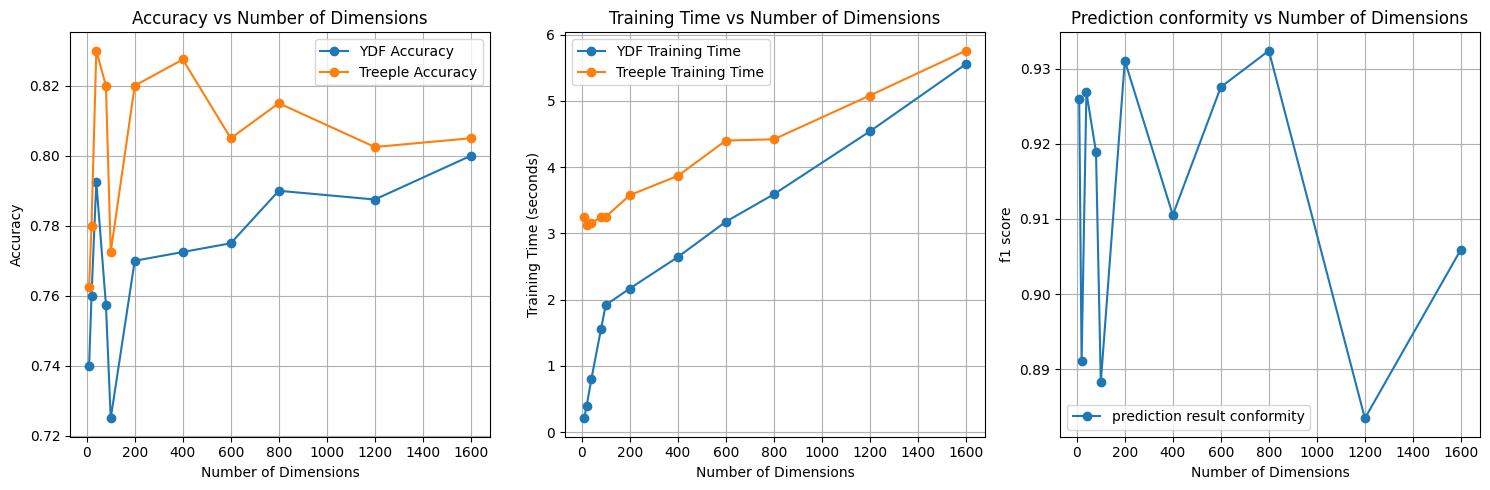

In [68]:

num_dims = [10, 20, 40, 80, 100, 200, 400, 600, 800, 1200, 1600]
n_samples = 2000
n_tree = 500
#def trunk_simulation(n_tree, num_dims, n_samples, params_treeple, params_ydf, n_rep=5, plot=True):
accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple, 
                                                                               params_ydf, 
                                                                               n_rep=1)

n_dim: 10 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.058108


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 10. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.7550, Training Time = 5.2862 sec
n_dim: 20 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.069200


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 20. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8025, Training Time = 4.9134 sec
n_dim: 40 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.069993


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 40. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8550, Training Time = 5.0950 sec
n_dim: 80 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.096191


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 80. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8475, Training Time = 5.2467 sec
n_dim: 100 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.108355


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 100. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8075, Training Time = 5.3652 sec
n_dim: 200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.107215


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 200. Setting n_informative to n_dim.
  warnings.warn(


Treeple: Accuracy = 0.8500, Training Time = 5.4421 sec
n_dim: 400 | n_tree: 500 | n_samples: 2000


c:\Users\clark\anaconda3\envs\catboost_env\lib\site-packages\treeple\datasets\hyppo.py:515: RuntimeWarning: Number of informative dimensions {n_informative} must be less than number of dimensions, 400. Setting n_informative to n_dim.
  warnings.warn(


Train model on 1600 examples
Model trained in 0:00:00.163029
Treeple: Accuracy = 0.8225, Training Time = 6.0665 sec
n_dim: 600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.194431
Treeple: Accuracy = 0.8250, Training Time = 6.3548 sec
n_dim: 800 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.257181
Treeple: Accuracy = 0.8050, Training Time = 6.7210 sec
n_dim: 1200 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.317047
Treeple: Accuracy = 0.8150, Training Time = 7.5632 sec
n_dim: 1600 | n_tree: 500 | n_samples: 2000
Train model on 1600 examples
Model trained in 0:00:00.393006
Treeple: Accuracy = 0.7900, Training Time = 8.4490 sec


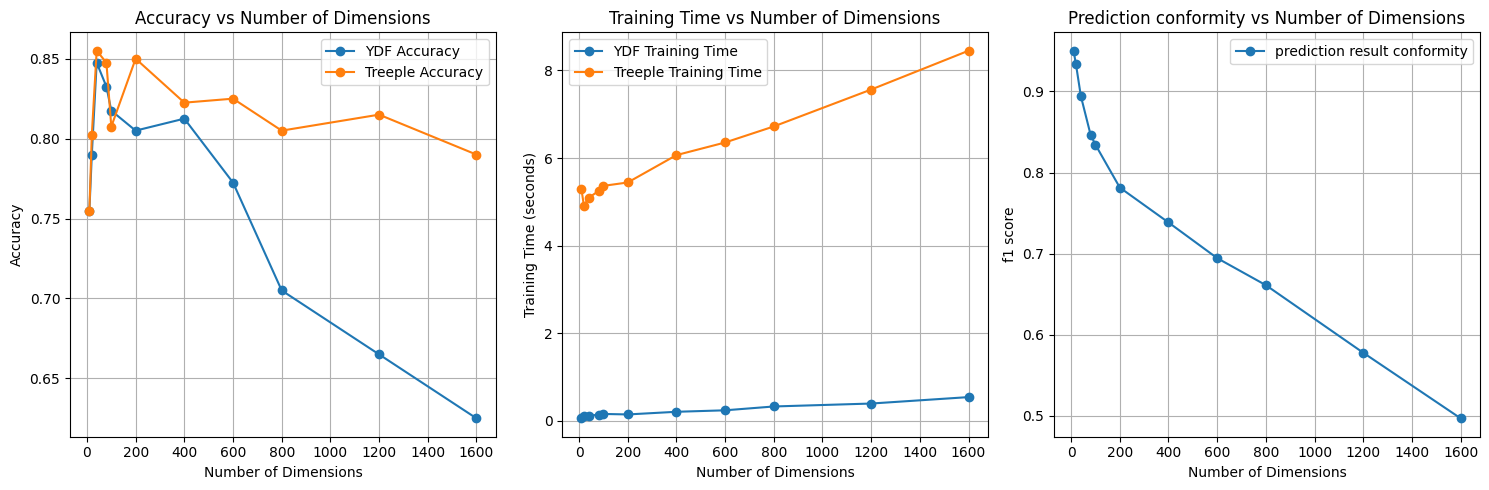

In [33]:
params_ydf1 = params_ydf.copy()  # Copy the original params for ydf
params_ydf1["growing_strategy"] = "LOCAL"

accs_ydf, times_ydf, accs_treeple, times_treeple, f1_scores = trunk_simulation(n_tree, 
                                                                               num_dims, 
                                                                               n_samples, 
                                                                               params_treeple, 
                                                                               params_ydf1, 
                                                                               n_rep=1)